In [1]:
import sys
sys.path.append('../.')
sys.path.append('../../.')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from synthcity.plugins.core.dataloader import GenericDataLoader
from synthcity.plugins import Plugins


/home/rob/miniconda3/envs/goggle2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Load data**

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

dataset = 'breast'
X = pd.read_csv('../data/breast_cancer_2.csv')

ind = list(range(len(X.columns)))
ind = [x for x in ind if x != X.columns.get_loc("target")]
col_list = X.columns[ind]
ct = ColumnTransformer([('scaler', StandardScaler(), col_list)], remainder='passthrough')

X_ = ct.fit_transform(X)
X = pd.DataFrame(X_, index=X.index, columns=X.columns)

X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,Worst texture,Worst perimeter,Worst area,Worst smoothness,Worst compactness,Worst concavity,Worst concave points,Worst symmetry,Worst fractal dimension,target
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,...,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015,1.0
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,...,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190,1.0
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,...,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391,1.0
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,...,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010,1.0
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,...,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100,1.0


**Fit model**

In [3]:
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_test = train_test_split(X, random_state=0, test_size=0.2, shuffle=True)
gens = Plugins()
print(gens.list())
gen = gens.get("tvae")

['survival_gan', 'timegan', 'dpgan', 'adsgan', 'timevae', 'tvae', 'survival_ctgan', 'fflows', 'pategan', 'survae', 'survival_nflow', 'nflow', 'rtvae', 'radialgan', 'bayesian_network', 'decaf', 'privbayes', 'ctgan']


In [17]:
gen.fit(X_train)

 60%|██████    | 600/1000 [00:07<00:05, 75.45it/s]


**Evaluate synthetic data**

In [18]:
X_synth = gen.generate(count=X_test.shape[0]).dataframe()
X_synth.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,Worst texture,Worst perimeter,Worst area,Worst smoothness,Worst compactness,Worst concavity,Worst concave points,Worst symmetry,Worst fractal dimension,target
0,1.856569,-0.486159,1.463525,1.302982,0.659165,0.178879,0.685881,2.052922,0.053683,0.885779,...,0.055793,1.653979,1.290864,0.552609,0.848869,1.242225,0.990541,-0.085074,-0.192060,0.0
1,-0.429862,-0.499660,-0.474323,-0.410892,-0.527992,-0.746698,-0.703801,-0.557388,-0.159060,-0.607238,...,0.692489,-0.618935,-0.543234,0.308994,-0.590645,-0.703547,-0.491150,-0.216961,-0.689823,0.0
2,-0.493633,-0.393282,-0.483100,-0.577761,-0.457106,-0.798162,-0.693321,-0.681419,-0.110154,-0.305561,...,0.187085,-0.593030,-0.571252,-0.648698,-0.663733,-0.825852,-0.710651,-0.287767,-0.530517,0.0
3,-0.231631,-0.267762,-0.274046,-0.379742,-0.552173,-0.658704,-0.682475,0.314556,0.054714,-0.473599,...,-0.706211,-0.284333,-0.369249,-0.489769,0.773116,0.236600,0.909046,0.102497,-0.301463,0.0
4,-0.541609,0.682824,-0.511208,-0.607537,-0.438555,-0.733602,-0.593812,-0.652594,-0.256896,-0.448164,...,0.488929,-0.644308,-0.639149,0.403435,-0.627297,-0.777907,-0.564808,-0.150189,-0.331024,1.0


In [19]:
from synthcity.metrics import eval_statistical
from synthcity.metrics import eval_detection
from synthcity.metrics import eval_performance

def evaluate_synthetic(X_synth, X_test):
    quality_evaluator = eval_statistical.AlphaPrecision()
    qual_res = quality_evaluator.evaluate(X_test, X_synth)
    print(qual_res)
    qual_score = np.mean(list(qual_res.values()))

    xgb_evaluator = eval_performance.PerformanceEvaluatorXGB()
    linear_evaluator = eval_performance.PerformanceEvaluatorLinear()
    mlp_evaluator = eval_performance.PerformanceEvaluatorMLP()
    xgb_score = xgb_evaluator.evaluate(X_test, X_synth)
    linear_score = linear_evaluator.evaluate(X_test, X_synth)
    mlp_score = mlp_evaluator.evaluate(X_test, X_synth)
    gt_perf = (xgb_score['gt'] + linear_score['gt'] + mlp_score['gt'])/3
    synth_perf = (xgb_score['syn_ood'] +
                    linear_score['syn_ood'] + mlp_score['syn_ood'])/3

    xgb_detector = eval_detection.SyntheticDetectionXGB()
    mlp_detector = eval_detection.SyntheticDetectionMLP()
    gmm_detector = eval_detection.SyntheticDetectionGMM()
    xgb_det = xgb_detector.evaluate(X_test, X_synth)
    mlp_det = mlp_detector.evaluate(X_test, X_synth)
    gmm_det = gmm_detector.evaluate(X_test, X_synth)
    det_score = (xgb_det['mean'] + mlp_det['mean'] + gmm_det['mean'])/3

    return qual_score, (gt_perf, synth_perf), det_score


X_synth_loader = GenericDataLoader(
    X_synth,
    target_column="target",
)
X_test_loader = GenericDataLoader(
    X_test,
    target_column="target",
)

res = evaluate_synthetic(X_synth_loader, X_test_loader)
print(f'Quality: {res[0]:.3f}')
print(f'Detection: {res[2]:.3f}')
print(f'Performance on real: {res[1][0]:.3f}, on synth: {res[1][1]:.3f}')
print(f'diff: {res[1][0] - res[1][1]:.3f}')

{'delta_precision_alpha_OC': 0.02280701754385983, 'delta_coverage_beta_OC': 0.0, 'authenticity_OC': 0.7543859649122807}
Quality: 0.259
Detection: 0.730
Performance on real: 0.980, on synth: 0.939
diff: 0.041


**Generate TSNE plots**

In [8]:
X_test['label'] = 'Original'
X_synth['label'] = 'Synthetic'

concat_df = pd.concat([X_test, X_synth], axis=0)
y_data = concat_df['label']
x_data = concat_df.drop(['label', 'target'], axis=1)

In [9]:
from sklearn.manifold import TSNE
import seaborn as sns

tsne = TSNE(n_components=2, verbose=0, random_state=0)
z = tsne.fit_transform(x_data)
df = pd.DataFrame()
df["y"] = y_data
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

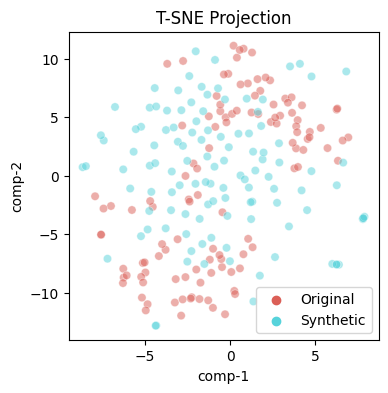

In [10]:
plt.figure(figsize=(4, 4))
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 2), alpha=0.5,
                data=df).set(title=f"T-SNE Projection")
plt.xlabel('comp-1')
plt.ylabel('comp-2')
plt.legend()

plt.show()

**Visualise adjacency matrix**

In [11]:
adj_matrix = gen.model.learned_graph(100).cpu().detach().numpy()
plt.figure(figsize=(4, 4))
im = plt.imshow(adj_matrix, cmap='inferno', interpolation='nearest', vmin=0, vmax=1.0)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title('Learned graph')
plt.axis('off')
plt.show()

AttributeError: 'TabularFlows' object has no attribute 'learned_graph'